In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline


import sys
sys.path.append('/usr/local/lib/python2.7/site-packages/')

import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import operator
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn import preprocessing
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import csv
import time

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,r2_score

In [4]:
#running on a windows machine, change filepaths as needed

train_df = pd.read_csv('Data\\train.csv')

In [5]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [7]:
print "Number of categories: {}".format(len(train_df.Category.unique()))
print "Summary of X"
print train_df.X.describe()
print "Summary of Y"
print train_df.Y.describe()

Number of categories: 39
Summary of X
count    878049.000000
mean       -122.422616
std           0.030354
min        -122.513642
25%        -122.432952
50%        -122.416420
75%        -122.406959
max        -120.500000
dtype: float64
Summary of Y
count    878049.000000
mean         37.771020
std           0.456893
min          37.707879
25%          37.752427
50%          37.775421
75%          37.784369
max          90.000000
dtype: float64


In [9]:
# Feature Names: address, dayofweek
streets = [w for w in train_df['Address'].str.split()] 
p = []
for s in streets:
    p.append([i for i in s if i.isupper() and len(i) > 2])

train_df['street'] = p

le = preprocessing.LabelEncoder()
dow = le.fit_transform(train_df.DayOfWeek.values)
dow_orig = le.classes_
addr = le.fit_transform(train_df.Address)
addr_orig = le.classes_
category = le.fit_transform(train_df.Category)
cat_orig = le.classes_
pdist = le.fit_transform(train_df.PdDistrict)
pd_orig = le.classes_
street = le.fit_transform(train_df.street)
street_orig = le.classes_


In [10]:
train_df['crime'] = category
train_df['addr'] = addr
train_df['dow'] = dow
train_df['pd'] = pdist
train_df['street'] = street

In [11]:
dates = pd.DatetimeIndex(train_df.Dates)

In [29]:
train_df['date'] = dates.date
train_df['time'] = dates.time
train_df['hour'] = dates.hour
train_df['minutes'] = dates.minute
train_df['month'] = dates.month
train_df['woy'] = dates.weekofyear
train_df['year'] = dates.year

train_df.ix[train_df.hour <12,'time_of_day'] = "morning"
train_df.ix[train_df.hour >=12,'time_of_day'] = "midday"
train_df.ix[train_df.hour >14,'time_of_day'] = "afternoon"
train_df.ix[train_df.hour >18,'time_of_day'] = "night"

le = preprocessing.LabelEncoder()
tod = le.fit_transform(train_df.time_of_day.values)
tod_orig = le.classes_

train_df['tod'] = tod

# Season
train_df.ix[train_df.month == 12,'seas'] = "winter"
train_df.ix[train_df.month == 1,'seas'] = "winter"
train_df.ix[train_df.month == 2,'seas'] = "winter"
train_df.ix[train_df.month == 3,'seas'] = "spring"
train_df.ix[train_df.month == 4,'seas'] = "spring"
train_df.ix[train_df.month == 5,'seas'] = "spring"
train_df.ix[train_df.month == 6,'seas'] = "summer"
train_df.ix[train_df.month == 7,'seas'] = "summer"
train_df.ix[train_df.month == 8,'seas'] = "summer"
train_df.ix[train_df.month == 9,'seas'] = "fall"
train_df.ix[train_df.month == 10,'seas'] = "fall"
train_df.ix[train_df.month == 11,'seas'] = "fall"

le = preprocessing.LabelEncoder()
season = le.fit_transform(train_df.seas.values)
season_orig = le.classes_

train_df['season'] = season

In [13]:
train_df_new = train_df[['date','year','month', 'woy', 'hour','minutes','time','tod', 'dow','season', 'pd','addr','street', 'X','Y','crime']]
train_df_new.head()

,date,year,month,woy,hour,minutes,time,tod,dow,season,pd,addr,street,X,Y,crime
0,2015-05-13,2015,5,20,23,53,23:53:00,3,6,1,4,19790,10076,-122.425892,37.774599,37
1,2015-05-13,2015,5,20,23,53,23:53:00,3,6,1,4,19790,10076,-122.425892,37.774599,21
2,2015-05-13,2015,5,20,23,33,23:33:00,3,6,1,4,22697,13528,-122.424363,37.800414,21
3,2015-05-13,2015,5,20,23,30,23:30:00,3,6,1,4,4266,8634,-122.426995,37.800873,16
4,2015-05-13,2015,5,20,23,30,23:30:00,3,6,1,5,1843,3183,-122.438738,37.771541,16


In [118]:
'''EVAN NEW STUFF'''

#Create binarized dummy arrays
dum_days = pd.get_dummies(train_df.DayOfWeek)
#dum_days.rename(columns=lambda x: "day_" + str(x))
print "Days as dummy"
print dum_days.shape

dum_pds = pd.get_dummies(train_df.PdDistrict)
print "\nDistrict as dummy"
print dum_pds.shape

dum_hours = pd.get_dummies(train_df_new.hour)
print "\nHours as dummy"
print dum_hours.shape

dum_season = pd.get_dummies(train_df.seas)
print "\nSeason as dummy"
print dum_season.shape

dum_tod = pd.get_dummies(train_df.time_of_day)
print "\ToD as dummy"
print dum_tod.shape

# TRIAL 1
#dum_cols = pd.concat([dum_days, dum_pds], axis=1)
#Acc = 0.219265788288
#LogLoss = 2.61856923059

#TRIAL 2
dum_cols = pd.concat([dum_days, dum_pds, dum_hours, dum_season], axis=1)
#0.222293171569
#2.58553584854

#TRIAL 3
#dum_cols = pd.concat([dum_days, dum_pds, dum_tod, dum_season], axis=1)
#0.221415173405
#2.60544577822

#TRIAL 4
#dum_cols = pd.concat([dum_days, dum_pds, dum_hours, dum_season], axis=1)
#0.222293171569
#2.58553584854

print "\Combined:"
print dum_cols.shape
print dum_cols.head()

Days as dummy
(878049, 7)

District as dummy
(878049, 10)

Hours as dummy
(878049, 24)

Season as dummy
(878049, 4)
\ToD as dummy
(878049, 4)
\Combined:
(878049, 45)
   Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday  BAYVIEW  \
0       0       0         0       0         0        0          1        0   
1       0       0         0       0         0        0          1        0   
2       0       0         0       0         0        0          1        0   
3       0       0         0       0         0        0          1        0   
4       0       0         0       0         0        0          1        0   

   CENTRAL  INGLESIDE    ...      18  19  20  21  22  23  fall  spring  \
0        0          0    ...       0   0   0   0   0   1     0       1   
1        0          0    ...       0   0   0   0   0   1     0       1   
2        0          0    ...       0   0   0   0   0   1     0       1   
3        0          0    ...       0   0   0   0   0   1     0       

In [119]:
'''EVAN NEW STUFF'''
#train_2 = pd.concat([train_df_new.crime, train_df_new.X, train_df_new.Y, dum_cols], axis=1)
#train_2 = pd.concat([train_df_new.crime, dum_cols], axis=1)

#Optimizing non-dummy cols on Trail2
train_2 = pd.concat([train_df_new.crime, train_df_new.X, train_df_new.Y, train_df_new.year, train_df_new.month, dum_cols], axis=1)
#0.222298872856
#2.58583128457

print train_2.shape
print train_2.head()

(878049, 50)
   crime           X          Y  year  month  Friday  Monday  Saturday  \
0     37 -122.425892  37.774599  2015      5       0       0         0   
1     21 -122.425892  37.774599  2015      5       0       0         0   
2     21 -122.424363  37.800414  2015      5       0       0         0   
3     16 -122.426995  37.800873  2015      5       0       0         0   
4     16 -122.438738  37.771541  2015      5       0       0         0   

   Sunday  Thursday    ...     18  19  20  21  22  23  fall  spring  summer  \
0       0         0    ...      0   0   0   0   0   1     0       1       0   
1       0         0    ...      0   0   0   0   0   1     0       1       0   
2       0         0    ...      0   0   0   0   0   1     0       1       0   
3       0         0    ...      0   0   0   0   0   1     0       1       0   
4       0         0    ...      0   0   0   0   0   1     0       1       0   

   winter  
0       0  
1       0  
2       0  
3       0  
4      

In [77]:
'''EVAN NEW STUFF'''
# import new stuff
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss

In [123]:
'''EVAN NEW STUFF'''
DEV_SIZE = 0.20
np.random.seed(0)
msk = np.random.rand(len(train_2)) < DEV_SIZE

dev = train_2[msk]
dev_labels = np.array(dev.crime)
dev.drop('crime',1,inplace=True)

train = train_2[~msk]  # inverse of boolean mask
train_labels = np.array(train.crime)
train.drop('crime',1,inplace=True)

print "Dev: " + str(dev.shape)
print "Train: " + str(train.shape)
print train_labels.shape
print dev_labels.shape

C:\Users\sbu\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame
C:\Users\sbu\Anaconda\lib\site-packages\IPython\kernel\__main__.py:11: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame


Dev: (175399, 49)
Train: (702650, 49)
(702650L,)
(175399L,)


In [124]:
'''EVAN NEW STUFF'''
features = [i for i in train.columns]
print features
print train[features][:5]

['X', 'Y', 'year', 'month', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN', 0L, 1L, 2L, 3L, 4L, 5L, 6L, 7L, 8L, 9L, 10L, 11L, 12L, 13L, 14L, 15L, 16L, 17L, 18L, 19L, 20L, 21L, 22L, 23L, 'fall', 'spring', 'summer', 'winter']
            X          Y  year  month  Friday  Monday  Saturday  Sunday  \
0 -122.425892  37.774599  2015      5       0       0         0       0   
1 -122.425892  37.774599  2015      5       0       0         0       0   
2 -122.424363  37.800414  2015      5       0       0         0       0   
3 -122.426995  37.800873  2015      5       0       0         0       0   
4 -122.438738  37.771541  2015      5       0       0         0       0   

   Thursday  Tuesday   ...     18  19  20  21  22  23  fall  spring  summer  \
0         0        0   ...      0   0   0   0   0   1     0       1       0   
1         0        0  

In [125]:
'''EVAN NEW STUFF'''
#train_data = np.array(train[features])
#dev_data = np.array(dev[features])

print train_data.shape
print dev_data.shape

model = BernoulliNB()
model.fit(train[features], train_labels)
preds = model.predict(dev[features])
print metrics.accuracy_score(dev_labels, preds)

llpreds = np.array(model.predict_proba(dev[features]))
print log_loss(dev_labels, llpreds)

(702650L, 19L)
(175399L, 19L)
0.222298872856
2.58583128457


In [38]:
# Split this into Dev and Training Data
DEV_SIZE = 0.20

# fix a random seed
np.random.seed(0)
# Create boolean mask
# np.random creates a vector of random values between 0 and 1
# Those values are filtered to create a binary mask
msk = np.random.rand(len(train_df_new)) < DEV_SIZE

dev = train_df_new[msk]
dev_labels = np.array(dev.crime)
dev.drop('crime',1,inplace=True)

train = train_df_new[~msk]  # inverse of boolean mask
train_labels = np.array(train.crime)
train.drop('crime',1,inplace=True)

print "Dev: " + str(dev.shape)
print "Train: " + str(train.shape)
#print "Test: " + str(test_df.shape)

C:\Users\sbu\Anaconda\lib\site-packages\IPython\kernel\__main__.py:13: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame
C:\Users\sbu\Anaconda\lib\site-packages\IPython\kernel\__main__.py:17: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame


Dev: (175399, 15)
Train: (702650, 15)


C:\Users\sbu\Anaconda\lib\site-packages\matplotlib\axes\_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


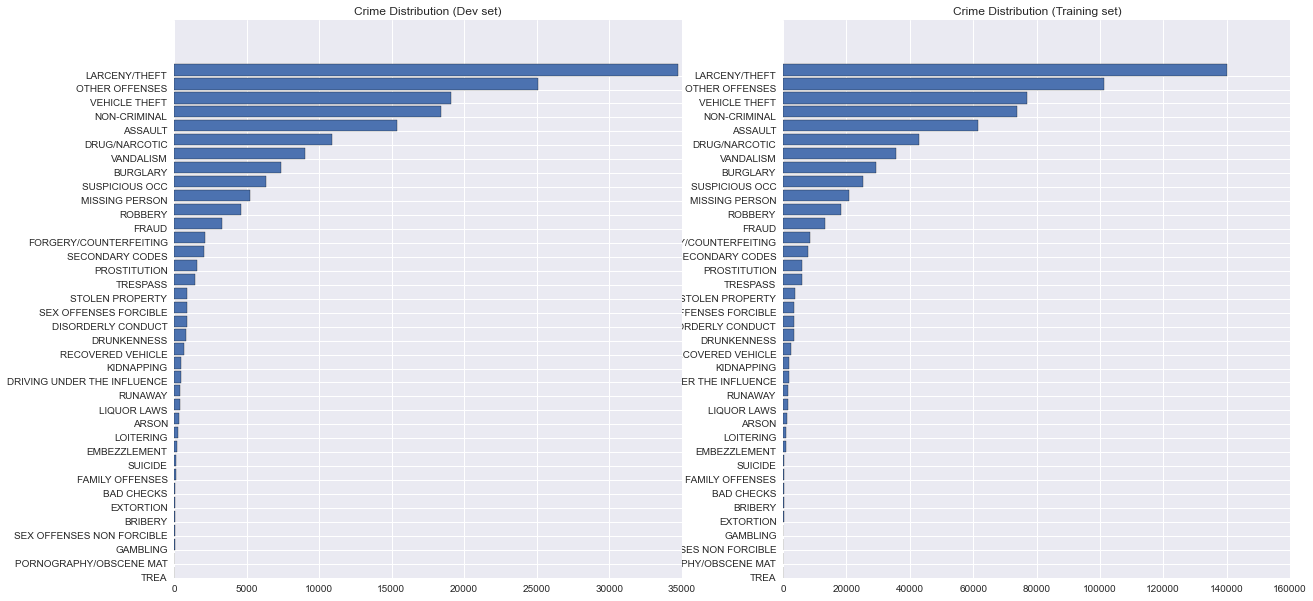

In [39]:
# make sure dev and train datasets have similar
# distribution for outcome variable
plt.figure(figsize=(20,10))
labels = [train_labels, dev_labels]
titles = ["Training set","Dev set"]
for i in [0,1]:
    plt.subplot(1,2,i)
    hist = np.histogram(labels[i], bins=range(38))
    ix = np.argsort(hist[0])
    plt.barh(range(37),hist[0][ix])
    x = plt.yticks(range(37),cat_orig[ix])
    ttl = "Crime Distribution ({})".format(titles[i])
    plt.title(ttl)

In [40]:
# convert training set to np array
train_data = np.array(train[['year','dow','tod', 'X', 'Y', 'street']])
dev_data = np.array(dev[['year','dow','tod', 'X', 'Y', 'street']])

# Gaussian NB
model = GaussianNB()
model.fit(train_data,train_labels)

preds = model.predict(dev_data)

In [41]:
accuracy = metrics.accuracy_score(dev_labels,preds)
print accuracy

0.0744017924846


In [23]:
# K- Nearest Neighbors

neighbors = 1

knn = KNeighborsClassifier(neighbors)
start_time = time.time()
knn.fit(train_data, train_labels)
print 'Train time = %.2f' %(time.time() - start_time)
start_time = time.time()
accuracy = knn.score(dev_data, dev_labels)
print 'Accuracy = %.4f' %(accuracy)
print 'Prediction time = %.2f' %(time.time() - start_time)

Train time = 2.03
Accuracy = 0.2328
Prediction time = 1.70


In [44]:
# Decision Tree

dt = DecisionTreeClassifier(criterion="entropy", splitter="best", random_state=0)
dt.fit(train_data, train_labels)

preds = dt.predict(dev_data)

accuracy = metrics.accuracy_score(dev_labels,preds)
print 'Accuracy (a decision tree):', accuracy


Accuracy (a decision tree): 0.248826960245


In [ ]:
rfc = RandomForestClassifier()
rfc.fit(train_data,train_labels)
preds = rfc.predict(dev_data)

accuracy = metrics.accuracy_score(dev_labels,preds)
print 'Accuracy (a random forest):', accuracy


In [16]:
bc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=0.1)

abc.fit(train_data, train_labels)
preds = abc.predict(dev_data)
accuracy = metrics.accuracy_score(dev_labels,preds)
print 'Accuracy (adaboost with decision trees):', accuracy


Accuracy (adaboost with decision trees): 0.208017149471


In [53]:
# Gradient Boosting Trees

params = {'n_estimators': 1000, 'max_depth': 6,
        'learning_rate': 0.01, 'alpha':0.001}

clf = GradientBoostingRegressor(**params).fit(train_data, train_labels)

preds = clf.predict(dev_data)
accuracy = metrics.accuracy_score(dev_labels,preds)
print 'Accuracy (GBT):', accuracy

# For me, the Mean Squared Error wasn't much informative and used instead the
# :math:`R^2` **coefficient of determination**. This measure is a number
# indicating how well a variable is able to predict the other. Numbers close to
# 0 means poor prediction and numbers close to 1 means perfect prediction. In the
# book, they claim a 0.84 against a 0.86 reported in the paper that created the
# dataset using a highly tuned algorithm. I'm getting a good 0.83 without much
# tunning of the parameters so it's a good out of the box technique.
 
mse = mean_squared_error(dev_labels, clf.predict(dev_data))
r2 = r2_score(dev_labels, clf.predict(dev_data))
 
print("MSE: %.4f" % mse)
print("R2: %.4f" % r2)

ValueError: Can't handle mix of multiclass and continuous